<a href="https://colab.research.google.com/github/Makoto-Noda/google-Colab/blob/main/CatsDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/jeffd23/catdognet-keras-convnet-starter

In [1]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import keras.utils

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import json
f = open("/content/drive/MyDrive/kaggle.json", 'r')
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

In [4]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 98% 801M/814M [00:05<00:00, 184MB/s]
100% 814M/814M [00:05<00:00, 150MB/s]


In [5]:
!unzip dogs-vs-cats-redux-kernels-edition.zip

Archive:  dogs-vs-cats-redux-kernels-edition.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               


In [ ]:
!unzip test.zip

In [ ]:
!unzip train.zip

トレーニングデータ・テストデータの作成

In [8]:
TRAIN_DIR = './train/'
TEST_DIR = './test/'

In [9]:
ROWS = 64
COLS = 64
CHANNELS = 3

In [10]:
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [11]:
train_images = train_dogs[:1000] + train_cats[:1000]
random.shuffle(train_images)
test_images =  test_images[:25]

In [29]:
def read_image(file_path):

    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

    return img


def prep_data(images):

    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))

    return data


train = prep_data(train_images)
test = prep_data(test_images)

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
Processed 0 of 25


In [30]:
labels = []

for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

labels = np.array(labels, dtype='float32')

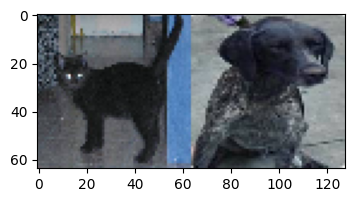

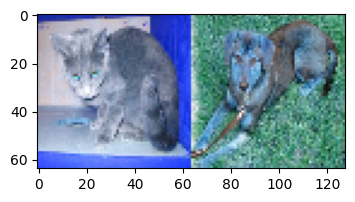

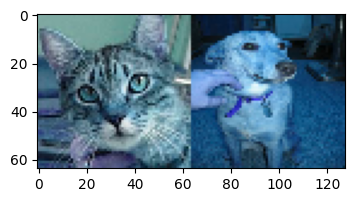

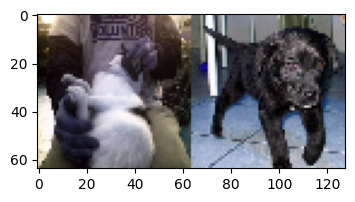

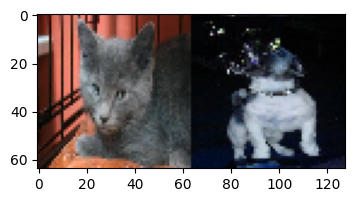

In [31]:
def show_cats_and_dogs(idx):

    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(5,2))
    plt.imshow(pair)
    plt.show()

    return idx

for idx in range(0,5):
    show_cats_and_dogs(idx)

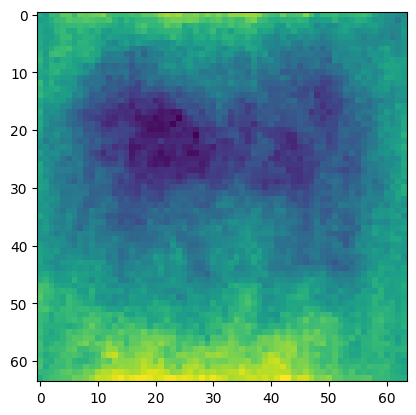

In [32]:
dog_avg = np.array([dog[0].T for i, dog in enumerate(train) if labels[i]==1]).mean(axis=0)
cat_avg = np.array([cat[0].T for i, cat in enumerate(train) if labels[i]==0]).mean(axis=0)

plt.imshow(dog_avg)

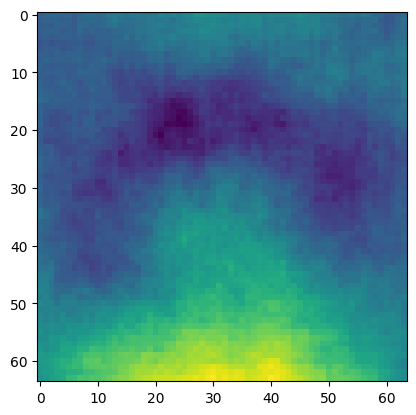

In [33]:
plt.imshow(cat_avg)

CatdogNet-16の実装

In [34]:
from keras.src.layers.convolutional.conv2d_transpose import Conv2D
optimizer = RMSprop(learning_rate=1e-4)
objective = 'binary_crossentropy'

def catdog():

    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(3, ROWS, COLS), activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    #model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))

    #model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
    #model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
    #model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

model = catdog()

In [35]:
nb_epochs = 20
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

def run_catdog():

    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, epochs=nb_epochs,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])


    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()

Epoch 12: early stopping


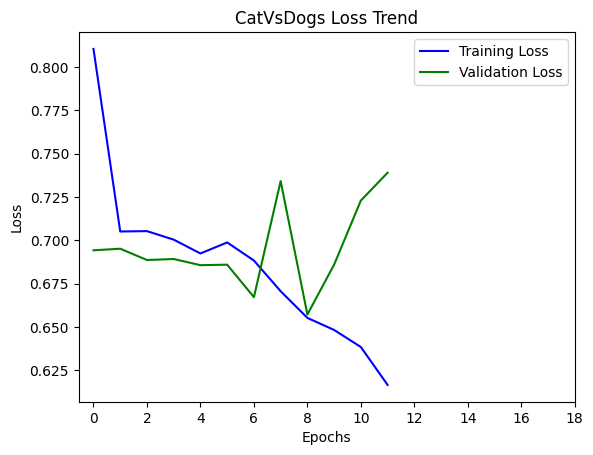

In [36]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CatVsDogs Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epochs)[0::2])
plt.legend()
plt.show()

I am 54.92% sure this is a Dog


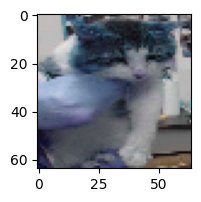

I am 69.66% sure this is a Cat


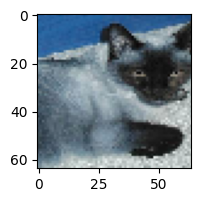

I am 95.86% sure this is a Cat


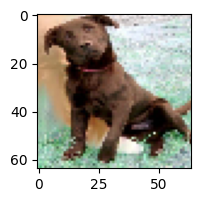

I am 56.83% sure this is a Cat


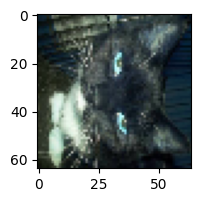

I am 55.83% sure this is a Dog


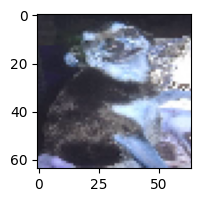

I am 74.84% sure this is a Dog


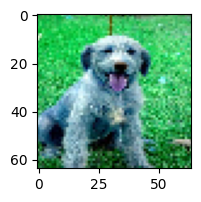

I am 83.72% sure this is a Cat


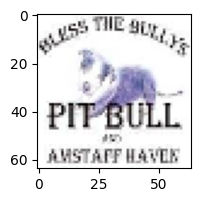

I am 87.75% sure this is a Cat


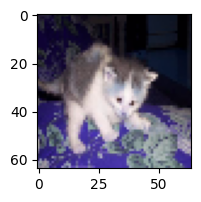

I am 65.98% sure this is a Cat


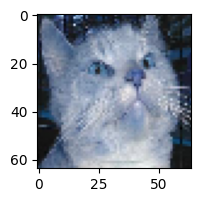

I am 77.70% sure this is a Cat


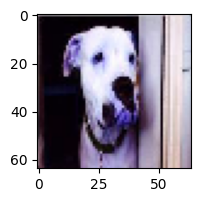

I am 68.54% sure this is a Cat


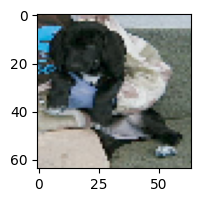

I am 95.65% sure this is a Cat


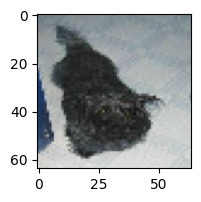

I am 95.58% sure this is a Cat


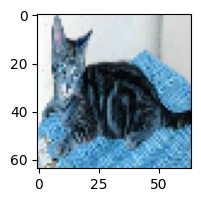

I am 71.43% sure this is a Cat


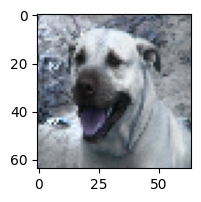

I am 92.20% sure this is a Cat


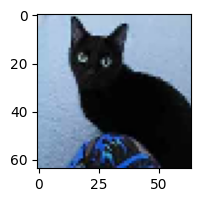

I am 74.84% sure this is a Cat


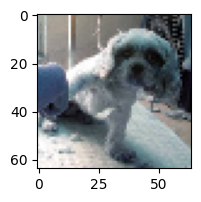

I am 60.02% sure this is a Cat


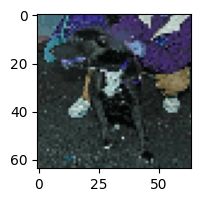

I am 50.79% sure this is a Dog


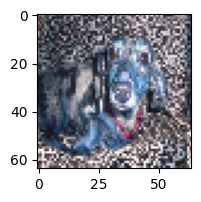

I am 57.95% sure this is a Dog


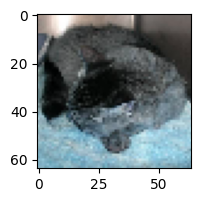

I am 55.00% sure this is a Dog


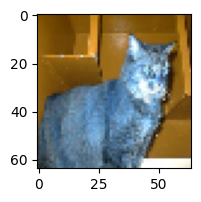

I am 57.67% sure this is a Cat


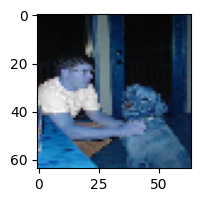

I am 61.52% sure this is a Dog


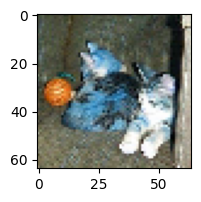

I am 58.65% sure this is a Cat


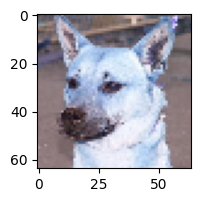

I am 89.73% sure this is a Cat


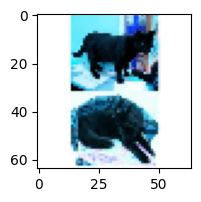

I am 52.60% sure this is a Cat


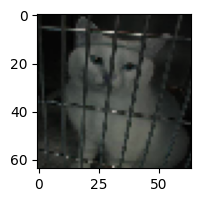

In [38]:
for i in range(0,25):
    if predictions[i, 0] >= 0.5:
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else:
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))

    plt.figure(figsize=(5,2))
    plt.imshow(test[i].T)
    plt.show()